In [14]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0" 
else:
    dev = "cpu"
print(dev)
device = torch.device(dev) 

cuda:0


In [3]:
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
else:
    print("no usable gpus")

Let's use 1 GPUs!


## Data Loading

In [4]:
def loadNpy(filename):
    with open(filename, "rb") as f: return np.load(f)

In [5]:
db = "14"
window_size = "10"
lag = "2"
features = "all"
save_dir = f"db{db}/window-size-{window_size}/lag{lag}/{features}-features/"

In [6]:
fdir = os.getcwd() + f"/train-val-test/{save_dir}"

if os.path.exists(fdir + "xx.npy"):
    xx = np.load(open(fdir + "xx.npy", "rb"))

if os.path.exists(fdir + "yy.npy"):
    yy = np.load(open(fdir + "yy.npy", "rb"))

In [7]:
xx.shape

(28952, 882)

In [8]:
data_type = ""
print(fdir)

/home/hwixley/Documents/4th-Year/Honours-Project/localhost-data-preprocessing/train-val-test/db14/window-size-10/lag2/all-features/


In [19]:
X_train, X_val, X_test = loadNpy(f"{fdir}X{data_type}_train.npy"), loadNpy(f"{fdir}X{data_type}_val.npy"), loadNpy(f"{fdir}X{data_type}_test.npy")
y_train, y_val, y_test = loadNpy(f"{fdir}y{data_type}_train.npy"), loadNpy(f"{fdir}y{data_type}_val.npy"), loadNpy(f"{fdir}y{data_type}_test.npy")

In [10]:
def npy_to_tensor(data):
    data = torch.from_numpy(data)
    return data

In [11]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train), npy_to_tensor(y_val), npy_to_tensor(y_test)

In [12]:
X_train = X_train[:,:,None,None]
X_val = X_val[:,:,None,None]
X_test = X_test[:,:,None,None]

In [13]:
X_train.shape

torch.Size([17370, 882, 1, 1])

# Denoising Autoencoder

In [77]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
                
We define a function that adds each noise when called from main function
Input & Output: np array
                
"""


def add_noise(img,noise_type="gaussian"):

    row,col=49,18
    img=img.astype(np.float32)

    if noise_type=="gaussian":
        mean=0
        var=1
        sigma=var**.5
        noise=np.random.normal(-5.9,5.9,img.shape)
        noise=noise.reshape(row,col)
        img=img+noise
        return img

    if noise_type=="speckle":
        noise=np.random.randn(row,col)
        noise=noise.reshape(row,col)
        img=img+img*noise
        return img

In [78]:
xtrain, xtest = X_train.reshape(X_train.shape[0],49,18), X_test.reshape(X_test.shape[0],49,18)
ytrain, ytest = y_train, y_test

In [79]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises=["gaussian","speckle"]
noise_ct=0
noise_id=0
traindata=np.zeros(xtrain.shape)



for idx in tqdm(range(len(xtrain))):
    if noise_ct<(len(xtrain)/2):
        noise_ct+=1
        traindata[idx]=add_noise(xtrain[idx],noise_type=noises[noise_id])
    else:
        print("\n{} noise addition completed to images".format(noises[noise_id]))
        noise_id+=1
        noise_ct=0

print("\n{} noise addition completed to images".format(noises[noise_id])) 

noise_ct=0
noise_id=0
testdata=np.zeros(xtest.shape)

for idx in tqdm(range(len(xtest))):
    if noise_ct<(len(xtest)/2):
        noise_ct+=1
        x=add_noise(xtest[idx],noise_type=noises[noise_id])
        testdata[idx]=x
    else:
        print("\n{} noise addition completed to images".format(noises[noise_id]))
        noise_id+=1
        noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

100%|███████████████████████████████████████████| 17370/17370 [00:00<00:00, 42130.29it/s]



gaussian noise addition completed to images

speckle noise addition completed to images


100%|█████████████████████████████████████████████| 5791/5791 [00:00<00:00, 41344.96it/s]


gaussian noise addition completed to images

speckle noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

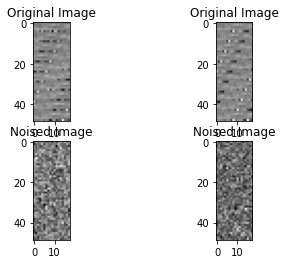

In [80]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0],cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0],cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[17000],cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[17000],cmap="gray")
axes[1,1].set_title("Noised Image")

In [81]:
class noisedDataset(Dataset):
  
    def __init__(self,datasetnoised,datasetclean,labels,transform):
        self.noise=datasetnoised
        self.clean=datasetclean
        self.labels=labels
        self.transform=transform
  
    def __len__(self):
        return len(self.noise)
  
    def __getitem__(self,idx):
        xNoise=self.noise[idx]
        xClean=self.clean[idx]
        y=self.labels[idx]

        if self.transform != None:
            xNoise=self.transform(xNoise)
            xClean=self.transform(xClean)

        return (xNoise,xClean,y)

In [82]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata,xtrain,ytrain,tsfms)
testset=noisedDataset(testdata,xtest,ytest,tsfms)

In [83]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""
batch_size=32

trainloader=DataLoader(trainset,batch_size=32,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)

In [84]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
    def __init__(self):
        super(denoising_model,self).__init__()
        self.encoder=nn.Sequential(
                      nn.Linear(882,600),
                      nn.ReLU(True),
                      nn.Linear(600,128),
                      nn.ReLU(True)

                      )

        self.decoder=nn.Sequential(
                      nn.Linear(128,600),
                      nn.ReLU(True),
                      nn.Linear(600,882),
                      nn.Sigmoid(),
                      )
 
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)

        return x

In [85]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available()==True:
    device="cuda:0"
else:
    device ="cpu"

model = denoising_model().to(device)
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)


epochs=50
l=len(trainloader)
losslist=list()
epochloss=0
running_loss=0
for epoch in range(epochs):
    print("Entering Epoch: ",epoch)
    for dirty,clean,label in tqdm((trainloader)):
        dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
        clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
        dirty,clean=dirty.to(device),clean.to(device)



        #-----------------Forward Pass----------------------
        output=model(dirty)
        loss=criterion(output,clean)
        #-----------------Backward Pass---------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        epochloss+=loss.item()
    #-----------------Log-------------------------------
    losslist.append(running_loss/l)
    running_loss=0
    print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))

Entering Epoch:  0


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 772.03it/s]


======> epoch: 0/50, Loss:0.012462773360311985
Entering Epoch:  1


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 770.01it/s]


======> epoch: 1/50, Loss:0.012380634434521198
Entering Epoch:  2


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 767.61it/s]


======> epoch: 2/50, Loss:0.011942910961806774
Entering Epoch:  3


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 768.69it/s]


======> epoch: 3/50, Loss:0.011456293985247612
Entering Epoch:  4


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 768.03it/s]


======> epoch: 4/50, Loss:0.011164571158587933
Entering Epoch:  5


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 770.05it/s]


======> epoch: 5/50, Loss:0.011893315240740776
Entering Epoch:  6


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 740.12it/s]


======> epoch: 6/50, Loss:0.01207385677844286
Entering Epoch:  7


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 739.58it/s]


======> epoch: 7/50, Loss:0.011547217145562172
Entering Epoch:  8


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 770.53it/s]


======> epoch: 8/50, Loss:0.011913093738257885
Entering Epoch:  9


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 770.08it/s]


======> epoch: 9/50, Loss:0.011198059655725956
Entering Epoch:  10


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 760.07it/s]


======> epoch: 10/50, Loss:0.011082331649959087
Entering Epoch:  11


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 766.78it/s]


======> epoch: 11/50, Loss:0.011086811311542988
Entering Epoch:  12


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 762.17it/s]


======> epoch: 12/50, Loss:0.010994826443493366
Entering Epoch:  13


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 770.03it/s]


======> epoch: 13/50, Loss:0.010568341240286827
Entering Epoch:  14


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 769.77it/s]


======> epoch: 14/50, Loss:0.010919740423560143
Entering Epoch:  15


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 758.96it/s]


======> epoch: 15/50, Loss:0.01076055783778429
Entering Epoch:  16


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 758.41it/s]


======> epoch: 16/50, Loss:0.011148822493851185
Entering Epoch:  17


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 762.69it/s]


======> epoch: 17/50, Loss:0.010189571417868137
Entering Epoch:  18


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 760.34it/s]


======> epoch: 18/50, Loss:0.01017671823501587
Entering Epoch:  19


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 759.88it/s]


======> epoch: 19/50, Loss:0.00975167565047741
Entering Epoch:  20


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 771.22it/s]


======> epoch: 20/50, Loss:0.009703499265015125
Entering Epoch:  21


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 771.93it/s]


======> epoch: 21/50, Loss:0.009363453835248947
Entering Epoch:  22


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 777.02it/s]


======> epoch: 22/50, Loss:0.00974344089627266
Entering Epoch:  23


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 774.45it/s]


======> epoch: 23/50, Loss:0.009413986466825008
Entering Epoch:  24


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 781.22it/s]


======> epoch: 24/50, Loss:0.009261232800781727
Entering Epoch:  25


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 770.51it/s]


======> epoch: 25/50, Loss:0.009301097132265568
Entering Epoch:  26


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 775.42it/s]


======> epoch: 26/50, Loss:0.008343740366399288
Entering Epoch:  27


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 778.03it/s]


======> epoch: 27/50, Loss:0.00785148236900568
Entering Epoch:  28


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 772.19it/s]


======> epoch: 28/50, Loss:0.00883518997579813
Entering Epoch:  29


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 763.17it/s]


======> epoch: 29/50, Loss:0.008294346742331982
Entering Epoch:  30


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 753.50it/s]


======> epoch: 30/50, Loss:0.007036604452878237
Entering Epoch:  31


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 757.67it/s]


======> epoch: 31/50, Loss:0.008453235030174255
Entering Epoch:  32


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 753.10it/s]


======> epoch: 32/50, Loss:0.007055866997689009
Entering Epoch:  33


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 755.53it/s]


======> epoch: 33/50, Loss:0.007058353163301945
Entering Epoch:  34


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 755.88it/s]


======> epoch: 34/50, Loss:0.006641881074756384
Entering Epoch:  35


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 754.41it/s]


======> epoch: 35/50, Loss:0.00841760728508234
Entering Epoch:  36


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 759.06it/s]


======> epoch: 36/50, Loss:0.0071765361353755
Entering Epoch:  37


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 761.90it/s]


======> epoch: 37/50, Loss:0.007178639993071556
Entering Epoch:  38


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 762.12it/s]


======> epoch: 38/50, Loss:0.007333995308727026
Entering Epoch:  39


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 766.01it/s]


======> epoch: 39/50, Loss:0.0065415995195508
Entering Epoch:  40


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 767.14it/s]


======> epoch: 40/50, Loss:0.006645505782216787
Entering Epoch:  41


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 771.39it/s]


======> epoch: 41/50, Loss:0.008654890581965446
Entering Epoch:  42


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 776.66it/s]


======> epoch: 42/50, Loss:0.006579114589840174
Entering Epoch:  43


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 774.00it/s]


======> epoch: 43/50, Loss:0.006234381813555956
Entering Epoch:  44


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 762.27it/s]


======> epoch: 44/50, Loss:0.007457603234797716
Entering Epoch:  45


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 763.69it/s]


======> epoch: 45/50, Loss:0.00713049340993166
Entering Epoch:  46


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 757.73it/s]


======> epoch: 46/50, Loss:0.005727588664740324
Entering Epoch:  47


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 768.66it/s]


======> epoch: 47/50, Loss:0.006240931339561939
Entering Epoch:  48


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 759.03it/s]


======> epoch: 48/50, Loss:0.006191660184413195
Entering Epoch:  49


100%|█████████████████████████████████████████████████| 543/543 [00:00<00:00, 753.45it/s]

======> epoch: 49/50, Loss:0.0062394700944423676


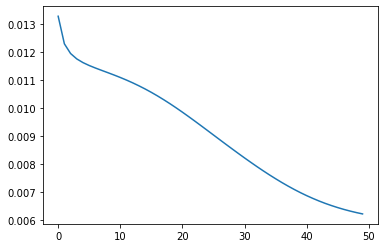

In [86]:
plt.plot(range(len(losslist)),losslist)

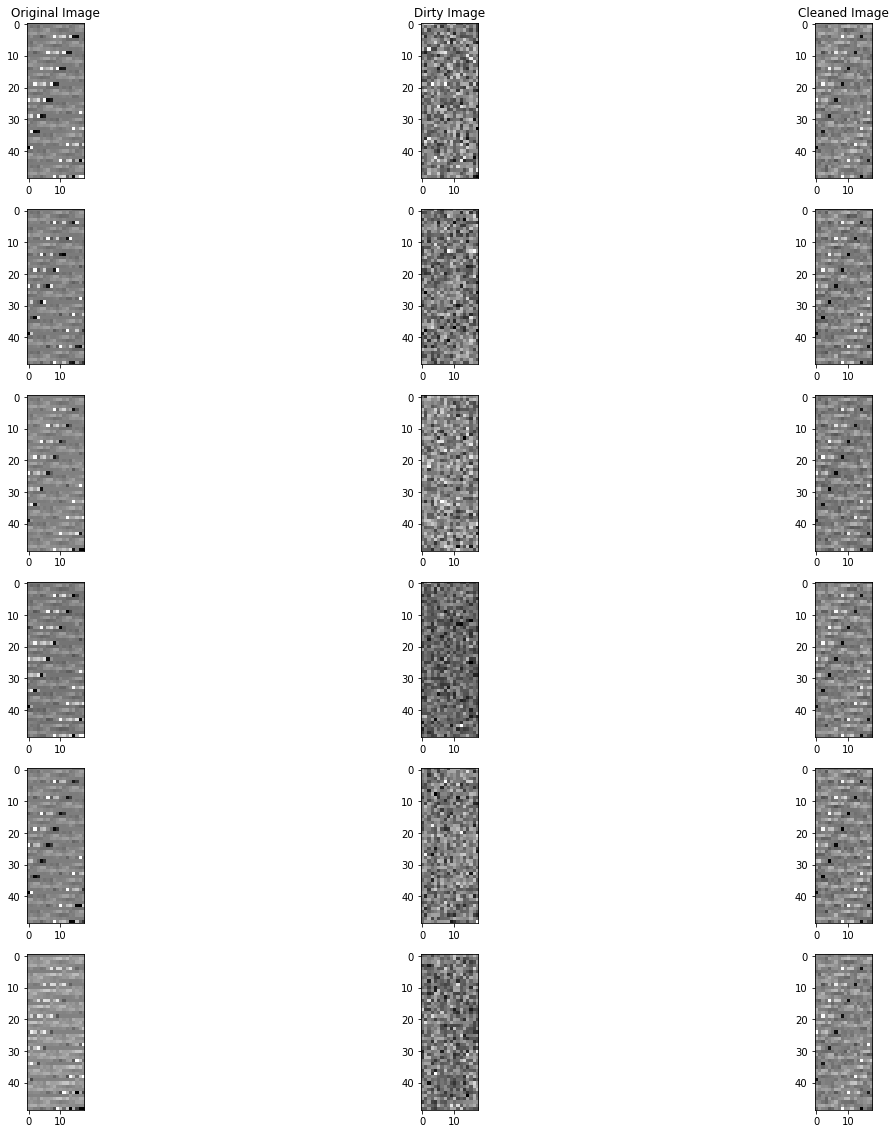

In [88]:
"""Here, we try to visualize some of the results.
  We randomly generate 6 numbers in between 1 and 10k , run them through the model,
  and show the results with comparisons
  
 """




f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,xtest.shape[0],size=6)
for idx in range((6)):
    dirty=testset[test_imgs[idx]][0]
    clean=testset[test_imgs[idx]][1]
    label=testset[test_imgs[idx]][2]
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    dirty=dirty.to(device)
    output=model(dirty)

    output=output.view(1,49,18)
    output=output.permute(1,2,0).squeeze(2)
    output=output.detach().cpu().numpy()

    dirty=dirty.view(1,49,18)
    dirty=dirty.permute(1,2,0).squeeze(2)
    dirty=dirty.detach().cpu().numpy()

    clean=clean.permute(1,2,0).squeeze(2)
    clean=clean.detach().cpu().numpy()

    axes[idx,0].imshow(clean,cmap="gray")
    axes[idx,1].imshow(dirty,cmap="gray")
    axes[idx,2].imshow(output,cmap="gray")
  

In [41]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve


def params_unwrap(param_vec, shapes, sizes):
    """Helper routine for minimize_list"""
    args = []
    pos = 0
    for i in range(len(shapes)):
        sz = sizes[i]
        args.append(param_vec[pos:pos+sz].reshape(shapes[i]))
        pos += sz
    return args


def params_wrap(param_list):
    """Helper routine for minimize_list"""
    param_list = [np.array(x) for x in param_list]
    shapes = [x.shape for x in param_list]
    sizes = [x.size for x in param_list]
    param_vec = np.zeros(sum(sizes))
    pos = 0
    for param in param_list:
        sz = param.size
        param_vec[pos:pos+sz] = param.ravel()
        pos += sz
    unwrap = lambda pvec: params_unwrap(pvec, shapes, sizes)
    return param_vec, unwrap


def minimize_list(cost, init_list, args):
    """Optimize a list of arrays (wrapper of scipy.optimize.minimize)
    The input function "cost" should take a list of parameters,
    followed by any extra arguments:
        cost(init_list, *args)
    should return the cost of the initial condition, and a list in the same
    format as init_list giving gradients of the cost wrt the parameters.
    The options to the optimizer have been hard-coded. You may wish
    to change disp to True to get more diagnostics. You may want to
    decrease maxiter while debugging. Although please report all results
    in Q2-5 using maxiter=500.
    The Matlab code comes with a different optimizer, so won't give the same
    results.
    """
    opt = {'maxiter': 500, 'disp': False}
    init, unwrap = params_wrap(init_list)
    def wrap_cost(vec, *args):
        E, params_bar = cost(unwrap(vec), *args)
        vec_bar, _ = params_wrap(params_bar)
        return E, vec_bar
    res = minimize(wrap_cost, init, args, 'L-BFGS-B', jac=True, options=opt)
    return unwrap(res.x)


def linreg_cost(params, X, yy, alpha):
    """Regularized least squares cost function and gradients
    Can be optimized with minimize_list -- see fit_linreg_gradopt for a
    demonstration.
    Inputs:
    params: tuple (ww, bb): weights ww (D,), bias bb scalar
         X: N,D design matrix of input features
        yy: N,  real-valued targets
     alpha: regularization constant
    Outputs: (E, [ww_bar, bb_bar]), cost and gradients
    """
    # Unpack parameters from list
    ww, bb = params

    # forward computation of error
    ff = np.dot(X, ww) + bb
    res = ff - yy
    E = np.dot(res, res) + alpha*np.dot(ww, ww)

    # reverse computation of gradients
    ff_bar = 2*res
    bb_bar = np.sum(ff_bar)
    ww_bar = np.dot(X.T, ff_bar) + 2*alpha*ww

    return E, [ww_bar, bb_bar]


def fit_linreg_gradopt(X, yy, alpha):
    """
    fit a regularized linear regression model with gradient opt
         ww, bb = fit_linreg_gradopt(X, yy, alpha)
     Find weights and bias by using a gradient-based optimizer
     (minimize_list) to improve the regularized least squares cost:
       np.sum(((np.dot(X,ww) + bb) - yy)**2) + alpha*np.dot(ww,ww)
     Inputs:
             X N,D design matrix of input features
            yy N,  real-valued targets
         alpha     scalar regularization constant
     Outputs:
            ww D,  fitted weights
            bb     scalar fitted bias
    """
    D = X.shape[1]
    args = (X, yy, alpha)
    init = (np.zeros(D), np.array(0))
    ww, bb = minimize_list(linreg_cost, init, args)
    return ww, bb


def logreg_cost(params, X, yy, alpha):
    """Regularized logistic regression cost function and gradients
    Can be optimized with minimize_list -- see fit_linreg_gradopt for a
    demonstration of fitting a similar function.
    Inputs:
    params: tuple (ww, bb): weights ww (D,), bias bb scalar
         X: N,D design matrix of input features
        yy: N,  real-valued targets
     alpha: regularization constant
    Outputs: (E, [ww_bar, bb_bar]), cost and gradients
    """
    # Unpack parameters from list
    ww, bb = params

    # Force targets to be +/- 1
    yy = 2*(yy==1) - 1

    # forward computation of error
    aa = yy*(np.dot(X, ww) + bb)
    sigma = 1/(1 + np.exp(-aa))
    E = -np.sum(np.log(sigma)) + alpha*np.dot(ww, ww)

    # reverse computation of gradients
    aa_bar = sigma - 1
    bb_bar = np.dot(aa_bar, yy)
    ww_bar = np.dot(X.T, yy*aa_bar) + 2*alpha*ww

    return E, (ww_bar, bb_bar)


def nn_cost(params, X, yy=None, alpha=None):
    """NN_COST simple neural network cost function and gradients, or predictions
           E, params_bar = nn_cost([ww, bb, V, bk], X, yy, alpha)
                    pred = nn_cost([ww, bb, V, bk], X)
     Cost function E can be minimized with minimize_list
     Inputs:
             params (ww, bb, V, bk), where:
                    --------------------------------
                        ww K,  hidden-output weights
                        bb     scalar output bias
                         V K,D hidden-input weights
                        bk K,  hidden biases
                    --------------------------------
                  X N,D input design matrix
                 yy N,  regression targets
              alpha     scalar regularization for weights
     Outputs:
                     E  sum of squares error
            params_bar  gradients wrt params, same format as params
     OR
               pred N,  predictions if only params and X are given as inputs
    """
    # Unpack parameters from list
    ww, bb, V, bk = params

    # Forwards computation of cost
    A = np.dot(X, V.T) + bk[None,:] # N,K
    P = 1 / (1 + np.exp(-A)) # N,K
    F = np.dot(P, ww) + bb # N,
    if yy is None:
        # user wants prediction rather than training signal:
        return F
    res = F - yy # N,
    E = np.dot(res, res) + alpha*(np.sum(V*V) + np.dot(ww,ww)) # 1x1

    # Reverse computation of gradients
    F_bar = 2*res # N,
    ww_bar = np.dot(P.T, F_bar) + 2*alpha*ww # K,
    bb_bar = np.sum(F_bar) # scalar
    P_bar = np.dot(F_bar[:,None], ww[None,:]) # N,
    A_bar = P_bar * P * (1 - P) # N,
    V_bar = np.dot(A_bar.T, X) + 2*alpha*V # K,
    bk_bar = np.sum(A_bar, 0)

    return E, (ww_bar, bb_bar, V_bar, bk_bar)


def rbf_fn(X1, X2):
    """Helper routine for gp_post_par"""
    return np.exp((np.dot(X1,(2*X2.T))-np.sum(X1*X1,1)[:,None]) - np.sum(X2*X2,1)[None,:])


def gauss_kernel_fn(X1, X2, ell, sigma_f):
    """Helper routine for gp_post_par"""
    return sigma_f**2 * rbf_fn(X1/(np.sqrt(2)*ell), X2/(np.sqrt(2)*ell))


def gp_post_par(X_rest, X_obs, yy, sigma_y=0.01, ell=5.0, sigma_f=0.01):
    """GP_POST_PAR means and covariances of a posterior Gaussian process
         rest_cond_mu, rest_cond_cov = gp_post_par(X_rest, X_obs, yy)
         rest_cond_mu, rest_cond_cov = gp_post_par(X_rest, X_obs, yy, sigma_y, ell, sigma_f)
     Calculate the means and covariances at all test locations of the posterior Gaussian
     process conditioned on the observations yy at observed locations X_obs.
     Inputs:
                 X_rest GP test locations
                  X_obs locations of observations
                     yy observed values
                sigma_y observation noise standard deviation
                    ell kernel function length scale
                sigma_f kernel function standard deviation
     Outputs:
           rest_cond_mu mean at each location in X_rest
          rest_cond_cov covariance matrix between function values at all test locations
    """
    X_rest = X_rest[:, None]
    X_obs = X_obs[:, None]
    K_rest = gauss_kernel_fn(X_rest, X_rest, ell, sigma_f)
    K_rest_obs = gauss_kernel_fn(X_rest, X_obs, ell, sigma_f)
    K_obs = gauss_kernel_fn(X_obs, X_obs, ell, sigma_f)
    M = K_obs + sigma_y**2 * np.eye(yy.size)
    M_cho, M_low = cho_factor(M)
    rest_cond_mu = np.dot(K_rest_obs, cho_solve((M_cho, M_low), yy))
    rest_cond_cov = K_rest - np.dot(K_rest_obs, cho_solve((M_cho, M_low), K_rest_obs.T))

    return rest_cond_mu, rest_cond_cov

In [51]:
def rmse(preds, labels):
    assert(preds.shape[0] == labels.shape[0])
    return np.sqrt(np.mean((labels - preds)**2))

def nn_rand_weights(xx, yy, alpha):
    inp_dim, h1_dim, out_dim = xx.shape[1], 20, 1
    
    V = init_rand_weights(h1_dim, inp_dim)
    bk = init_rand_weights(h1_dim, 1)
    ww = init_rand_weights(h1_dim, out_dim)
    bb = init_rand_weights(1, 1)

    return fit_neural_net((ww, bb, V, bk), (xx, yy, alpha))

def nn_q3_weights(xx, yy, alpha):
    return fit_neural_net(q3_weights(xx, yy, alpha), (xx, yy, alpha))

def fit_neural_net(init, args):
    return minimize_list(nn_cost, init, args)

def init_rand_weights(dim1, dim2):
    np.random.seed(123)
    lower, upper = -(1.0 / np.sqrt(dim2)), (1.0 / np.sqrt(dim2))
    nums = np.random.normal(0, 0.1, (dim1, dim2))
    
    if dim2 == 1:
        output = (lower + nums*(upper-lower)).reshape(dim1)
        if dim1 == 1:
            output = output[0]
    else:
        output = lower + nums*(upper-lower)
        
    return output

In [56]:
from scipy.stats import norm

def train_nn_reg(alpha):
    w = nn_rand_weights(X_train, y_train, alpha)
    return nn_rmse(w, X_val, y_val)

def nn_rmse(w, xx, yy):
    return rmse(nn_cost(w, xx), yy)

def alphas_performance(alphas):
    alpha_preds = []
    for a in alphas:
        alpha_preds.append(train_nn_reg(a))   
    return np.asarray(alpha_preds)

def PI(alpha_rest, alpha_obs, ys):   
    gpp_mu, gpp_cov = gp_post_par(alpha_rest, alpha_obs, ys)
    return norm.cdf(np.divide(gpp_mu - np.max(ys),np.sqrt(np.diag(gpp_cov))))

def calc_ys(alpha_obs):
    #return np.log(0.2700261059757441) - 
    return np.log(alphas_performance(alpha_obs))

def get_best_alpha(alpha_range):
    iterations, num_samples = 5, 3
    
    alpha_obs = [alpha_range[int((j/(num_samples-1))*(alpha_range.size-1))] for j in range(num_samples)]
    ys_obs = calc_ys(np.array(alpha_obs)).tolist()
    best_alphas = []
  
    for i in range(iterations):  
        cdf = PI(alpha_range, np.asarray(alpha_obs, dtype=float), np.asarray(ys_obs, dtype=float))
        
        best_alpha_idxs = np.where(cdf == np.max(cdf))[0]
        probs = [cdf[i] for i in best_alpha_idxs]
        best_alpha_idx = np.random.choice(best_alpha_idxs, 1, p=probs/np.sum(probs))
        best_alpha = alpha_range[best_alpha_idx]
        
        # If this alpha has already been observed then we try the next best one
        while best_alpha in alpha_obs:
            cdf[best_alpha_idx] = 0
            best_alpha_idxs = np.where(cdf == np.max(cdf))[0]
            probs = [cdf[i] for i in best_alpha_idxs]
            best_alpha_idx = np.random.choice(best_alpha_idxs, 1, p=probs/np.sum(probs))
            best_alpha = alpha_range[best_alpha_idx]
        
        y = calc_ys(np.asarray(best_alpha, dtype=float))
        
        best_alphas.append(best_alpha[0])
        ys_obs.append(y[0])
        alpha_obs.append(best_alpha[0])
        
    val_scores = np.zeros(iterations)
    for i, a in enumerate(best_alphas):
        val_scores[i] = train_nn_reg(a)

    best_alpha = best_alphas[np.where(val_scores == np.min(val_scores))[0][0]]
    w = nn_rand_weights(X_train, y_train, best_alpha)
        
    return best_alpha, np.min(val_scores), nn_rmse(w, X_test, y_test)

In [57]:
alpha_range = np.arange(0,50,0.02)
best_alpha, val_rmse, test_rmse = get_best_alpha(alpha_range)

print(f"Best alpha={best_alpha}, val_RMSE={val_rmse}, test_RMSE={test_rmse}")

Best alpha=11.34, val_RMSE=0.2848999436610508, test_RMSE=0.2839215619017199


In [31]:
#from tensorflow.keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model

ModuleNotFoundError: No module named 'keras'

In [9]:
import tensorflow as tf
tf.config.get_visible_devices()

2022-02-16 16:46:30.293263: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-16 16:46:30.293752: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-16 16:46:30.334140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 16:46:30.334230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.77GiB deviceMemoryBandwidth: 707.88GiB/s
2022-02-16 16:46:30.334244: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-16 16:46:30.335251: I tensorflow/stream_executor/platform/def

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

form/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-02-16 16:46:30.336183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-02-16 16:46:30.336317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-02-16 16:46:30.337299: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2022-02-16 16:46:30.337845: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusparse.so.10
2022-02-16 16:46:30.339942: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-16 16:46:30.339999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so

In [49]:
r,c = X_train.shape[0], X_train.shape[1]

encoding_dim = 29
input_data = Input(shape=(c,))
# encoded representation of input
encoded = Dense(encoding_dim, activation='relu')(input_data)
# decoded representation of code 
decoded = Dense(c, activation='sigmoid')(encoded)
# Model which take input image and shows decoded images
autoencoder = Model(input_data, decoded)

In [50]:
# This model shows encoded images
encoder = Model(input_data, encoded)
# Creating a decoder model
encoded_input = Input(shape=(encoding_dim,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [51]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [52]:
with tf.device('/gpu:0'):
    autoencoder.fit(X_train, X_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(X_val, X_val))

Epoch 1/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6903 - val_loss: 0.6804
Epoch 2/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6797 - val_loss: 0.6781
Epoch 3/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6779 - val_loss: 0.6769
Epoch 4/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6768 - val_loss: 0.6761
Epoch 5/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6762 - val_loss: 0.6757
Epoch 6/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6757 - val_loss: 0.6753
Epoch 7/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6754 - val_loss: 0.6750
Epoch 8/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6751 - val_loss: 0.6747
Epoch 9/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6748 - val_loss: 0.6744
Epoch 10/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6745 - val_loss: 0.6742


In [32]:
#x = x_test[0,:].reshape(1,-1)
#print(x.shape)
encoded_d = encoder.predict(x_test)#[0,:])#.reshape(None,c))
decoded_d = decoder.predict(encoded_d)#test[0,:].reshape(None,c))

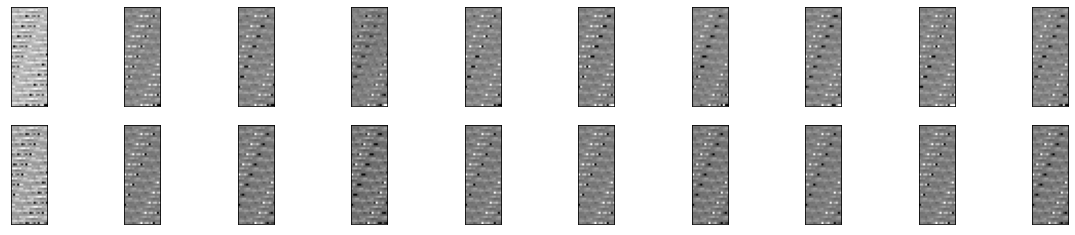

In [33]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # Display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(49, 18))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_d[i].reshape(49, 18))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [53]:
with tf.device('/gpu:0'):
    nx_train = decoder.predict(encoder.predict(X_train))
    nx_val = decoder.predict(encoder.predict(X_val))
    nx_test = decoder.predict(encoder.predict(X_test))

In [14]:
with tf.device('/gpu:0'):
    x = Input(shape=(882,1,1)) 

    # Encoder
    conv1_1 = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    pool1 = MaxPooling2D((2, 1), padding='same')(conv1_1)
    conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((1, 1), padding='same')(conv1_2)

    conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
    up2 = UpSampling2D((2, 1))(conv2_2)
    conv2_3 = Conv2D(4, (3, 3), activation='sigmoid', padding='same')(up2) #<--- ADD PADDING HERE
    up3 = UpSampling2D((1, 1))(conv2_3)
    r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

    model = Model(inputs=x, outputs=r)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 882, 1, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 882, 1, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 441, 1, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 441, 1, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 441, 1, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 441, 1, 8)         584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 882, 1, 8)         0     

In [ ]:
with tf.device('/gpu:0'):
    print("yes")
    model.fit(X_train, X_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(X_val, X_val))

In [129]:
model = Sequential()
# encoder network
model.add(Conv2D(30, 3, activation= 'relu', padding='same', input_shape = (49,18, 1)))
model.add(MaxPooling2D((1,2), padding= 'same'))
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D((1,1), padding= 'same'))
#decoder network
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D((1, 2)))
model.add(Conv2D(30, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D((1,1)))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer
model.compile(optimizer= 'adam', loss = 'binary_crossentropy')
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 49, 18, 30)        300       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 49, 9, 30)         0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 49, 9, 15)         4065      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 49, 9, 15)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 49, 9, 15)         2040      
_________________________________________________________________
up_sampling2d_24 (UpSampling (None, 49, 18, 15)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 49, 18, 30)      

In [128]:
with tf.device('/gpu:0'):
    model.fit(X_train, X_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(X_val, X_val))

Epoch 1/15


ValueError: in user code:

    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 882, 2, 30) vs (None, 882, 1, 1))


In [112]:
X_train.shape

TensorShape([17370, 882, 1, 1])

In [111]:
y_val.shape

TensorShape([5791])

In [54]:
def plot_time(data):
    plt.plot(np.arange(0.1, 1.1, 0.1), data)
    plt.ylim(-1.1,1.1)
    
def plot_recording(data):
    plt.clf()
    idxs = [i*88 for i in range(10)]
    ecg = [data[j:j+13] for j in idxs]
    plot_time(ecg)
    p_acc_x = [data[j+13:j+33] for j in idxs]
    plot_time(p_acc_x)
    p_acc_y = [data[j+33:j+53] for j in idxs]
    plot_time(p_acc_y)
    p_acc_z = [data[j+53:j+73] for j in idxs]
    plot_time(p_acc_z)
    acc_x = [data[j+73] for j in idxs]
    plot_time(acc_x)
    acc_y = [data[j+74] for j in idxs]
    plot_time(acc_y)
    acc_z = [data[j+75] for j in idxs]
    plot_time(acc_z)
    gyr_x = [data[j+76] for j in idxs]
    plot_time(gyr_x)
    gyr_y = [data[j+77] for j in idxs]
    plot_time(gyr_y)
    gyr_z = [data[j+78] for j in idxs]
    plot_time(gyr_z)
    gra_x = [data[j+79] for j in idxs]
    plot_time(gra_x)
    gra_y = [data[j+80] for j in idxs]
    plot_time(gra_y)
    gra_z = [data[j+81] for j in idxs]
    plot_time(gra_z)
    mag_x = [data[j+82] for j in idxs]
    plot_time(mag_x)
    mag_y = [data[j+83] for j in idxs]
    plot_time(mag_y)
    mag_z = [data[j+84] for j in idxs]
    plot_time(mag_z)
    att_roll = [data[j+85] for j in idxs]
    plot_time(att_roll)
    att_pitch = [data[j+86] for j in idxs]
    plot_time(att_pitch)
    att_yaw = [data[j+87] for j in idxs]
    plot_time(att_yaw)
    plt.show()

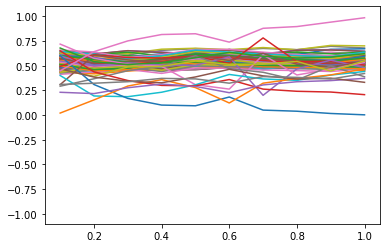

In [55]:
plot_recording(X_train[0,:])

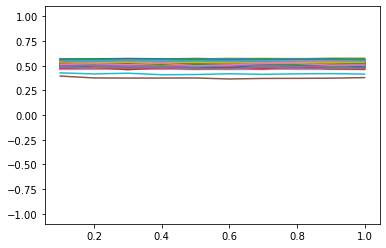

In [56]:
plot_recording(nx_train[0,:])

In [23]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def postMetrics(true, preds, fname):
    print("MSE: " + str(metrics.mean_squared_error(true, y_pred)))
    print("Accuracy: " + str(metrics.accuracy_score(true, y_pred)))
    print(confusion_matrix(true, y_pred))
    print()

In [24]:
from sklearn.neural_network import MLPClassifier
nn_size = (500,400,500)
clf = MLPClassifier(hidden_layer_sizes=nn_size, random_state=42)
clf.fit(nx_train, y_train)

/home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(500, 400, 500), random_state=42)

In [41]:
y_pred = clf.predict(nx_val)

postMetrics(y_val, y_pred, f"mlp-{nn_size}-val")


y_pred = clf.predict(nx_test)

postMetrics(y_test, y_pred, f"mlp-{nn_size}-test")

MSE: 0.1264030391987567
Accuracy: 0.8735969608012433
[[4786  174]
 [ 558  273]]

MSE: 0.12450353997582456
Accuracy: 0.8754964600241755
[[4796  180]
 [ 541  274]]



In [54]:
2*882/3

588.0

In [ ]:
from sklearn.neural_network import MLPClassifier
nn_size = (500,400,500)
clf = MLPClassifier(hidden_layer_sizes=nn_size, random_state=42)
clf.fit(X_train, y_train)

In [44]:
y_pred = clf.predict(X_val)

postMetrics(y_val, y_pred, f"mlp-{nn_size}-val")


y_pred = clf.predict(X_test)

postMetrics(y_test, y_pred, f"mlp-{nn_size}-test")

MSE: 0.10999827318252461
Accuracy: 0.8900017268174754
[[4656  304]
 [ 333  498]]

MSE: 0.10585391124158176
Accuracy: 0.8941460887584183
[[4674  302]
 [ 311  504]]

